Loading CSVs...
Loaded.
Numeric columns used: ['ApplicantYears', 'AnnualEarnings', 'RequestedSum', 'TrustMetric', 'WorkDuration', 'ActiveAccounts', 'OfferRate', 'RepayPeriod', 'DebtFactor']
Train/valid shapes: (163421, 9) (40856, 9)
Loaded model_full_bal.pkl
Loaded model_small_bal.pkl
Best thresholds: full = 0.17 , small = 0.19

Comparison:
              Model  Threshold  Accuracy  Precision  Recall      F1  ROC_AUC
0   FULL (default)       0.50    0.8843     0.5602  0.0225  0.0433   0.7355
1  SMALL (default)       0.50    0.8841     0.5426  0.0215  0.0413   0.7350
2      FULL (best)       0.17    0.7771     0.2622  0.5052  0.3452   0.7355
3     SMALL (best)       0.19    0.8029     0.2807  0.4447  0.3442   0.7350
Saved: svm_full_vs_small_comparison_final.csv


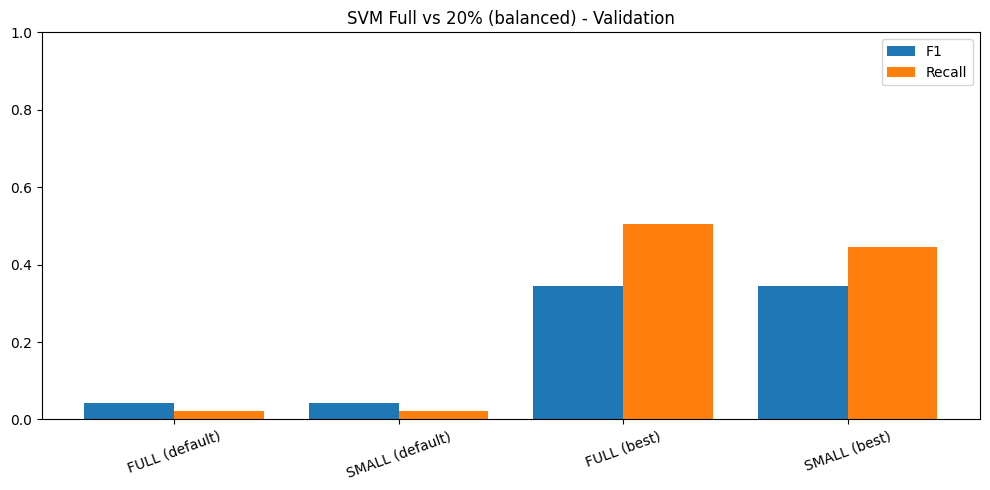

Saved: svm_full_vs_small_comparison_final.png
Saved: submission_final_threshold_0.17.csv and submission_final_probs.csv

All done. Files in notebook folder:
- model_full_bal.pkl, model_small_bal.pkl
- svm_full_vs_small_comparison_final.csv, .png
- submission_final_threshold_0.17.csv, submission_final_probs.csv


In [9]:
# ========== Unified: train/load balanced SVMs, threshold-tune, compare, save ==========
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score, roc_auc_score)
from sklearn.model_selection import train_test_split

# --------- User paths / settings (change if needed) ----------
train_path       = "train_preprocessed.csv"
small_train_path = "train_small_20.csv"
real_test_path   = "test_updated (1).csv"   # unlabeled real test for submission
profile_col      = "ProfileID"
target_col       = "RiskFlag"
model_full_file  = "model_full_bal.pkl"
model_small_file = "model_small_bal.pkl"
calib_cv         = 3
thresholds       = np.arange(0.01, 0.91, 0.01)
random_state     = 42

# --------- Helpers ----------
def canonicalize_booleans(df):
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object:
            vals = set(df[c].dropna().astype(str).unique())
            if vals.issubset({"True","False"}):
                df[c] = df[c].map({"True":1,"False":0})
    return df

def ensure_cols(df, cols):
    df = df.copy()
    for c in cols:
        if c not in df.columns:
            df[c] = 0
    return df

def train_calibrated_balanced_linear_svc(X, y, cv=3, n_jobs=-1):
    base = Pipeline([("scaler", StandardScaler()), ("svc", LinearSVC(class_weight="balanced", random_state=random_state, max_iter=20000))])
    calibrated = CalibratedClassifierCV(base, cv=cv, n_jobs=n_jobs)
    calibrated.fit(X, y)
    return calibrated

def evaluate_at_threshold(probs, y, thr):
    preds = (probs >= thr).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "precision": precision_score(y, preds, zero_division=0),
        "recall": recall_score(y, preds, zero_division=0),
        "f1": f1_score(y, preds, zero_division=0)
    }

# --------- Load data ----------
print("Loading CSVs...")
train_df = pd.read_csv(train_path)
small_train_df = pd.read_csv(small_train_path)
test_real = pd.read_csv(real_test_path)   # may be unlabeled
print("Loaded.")

# --------- Preprocess boolean-like cols ----------
train_df = canonicalize_booleans(train_df)
small_train_df = canonicalize_booleans(small_train_df)
test_real = canonicalize_booleans(test_real)

# --------- Determine numeric features from train ----------
numeric_cols = train_df.drop(columns=[target_col, profile_col], errors='ignore').select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns used:", numeric_cols)

# --------- Ensure consistent columns ----------
train_df = ensure_cols(train_df, numeric_cols)
small_train_df = ensure_cols(small_train_df, numeric_cols)
test_real = ensure_cols(test_real, numeric_cols)

# --------- Build stratified train/validation from full train ----------
train_part, valid_part = train_test_split(train_df, test_size=0.20, stratify=train_df[target_col], random_state=random_state)
X_train_full = train_part[numeric_cols].astype(float); y_train_full = train_part[target_col].astype(int)
X_valid = valid_part[numeric_cols].astype(float); y_valid = valid_part[target_col].astype(int)
X_train_small = small_train_df[numeric_cols].astype(float); y_train_small = small_train_df[target_col].astype(int)
X_test_real = test_real[numeric_cols].astype(float)

print("Train/valid shapes:", X_train_full.shape, X_valid.shape)

# --------- Train or load models ----------
if os.path.exists(model_full_file):
    model_full = joblib.load(model_full_file)
    print(f"Loaded {model_full_file}")
else:
    print("Training full model...")
    model_full = train_calibrated_balanced_linear_svc(X_train_full, y_train_full, cv=calib_cv, n_jobs=-1)
    joblib.dump(model_full, model_full_file)
    print(f"Saved {model_full_file}")

if os.path.exists(model_small_file):
    model_small = joblib.load(model_small_file)
    print(f"Loaded {model_small_file}")
else:
    print("Training small model...")
    model_small = train_calibrated_balanced_linear_svc(X_train_small, y_train_small, cv=calib_cv, n_jobs=-1)
    joblib.dump(model_small, model_small_file)
    print(f"Saved {model_small_file}")

# --------- Get validation probabilities ----------
probs_full_val = model_full.predict_proba(X_valid)[:,1]
probs_small_val = model_small.predict_proba(X_valid)[:,1]
y_val = y_valid.values

# --------- Find best threshold (max F1) for each model ----------
def find_best_threshold(probs, y):
    best_t, best_f1 = 0.5, -1
    for t in thresholds:
        p = (probs >= t).astype(int)
        f1 = f1_score(y, p, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1; best_t = t
    return best_t

best_t_full = find_best_threshold(probs_full_val, y_val)
best_t_small = find_best_threshold(probs_small_val, y_val)
print("Best thresholds: full =", best_t_full, ", small =", best_t_small)

# --------- Build comparison table: default & best thresholds ----------
rows = []
for name, probs, thr in [
    ("FULL (default)", probs_full_val, 0.5),
    ("SMALL (default)", probs_small_val, 0.5),
    ("FULL (best)", probs_full_val, best_t_full),
    ("SMALL (best)", probs_small_val, best_t_small),
]:
    eval_metrics = evaluate_at_threshold(probs, y_val, thr)
    auc = roc_auc_score(y_val, probs)
    rows.append([name, thr, eval_metrics["accuracy"], eval_metrics["precision"], eval_metrics["recall"], eval_metrics["f1"], auc])

df_compare = pd.DataFrame(rows, columns=["Model","Threshold","Accuracy","Precision","Recall","F1","ROC_AUC"]).round(4)
print("\nComparison:\n", df_compare)
df_compare.to_csv("svm_full_vs_small_comparison_final.csv", index=False)
print("Saved: svm_full_vs_small_comparison_final.csv")

# --------- Plot comparison ----------
plt.figure(figsize=(10,5))
x = np.arange(len(df_compare))
plt.bar(x - 0.2, df_compare["F1"], width=0.4, label="F1")
plt.bar(x + 0.2, df_compare["Recall"], width=0.4, label="Recall")
plt.xticks(x, df_compare["Model"], rotation=20)
plt.ylim(0,1)
plt.title("SVM Full vs 20% (balanced) - Validation")
plt.legend()
plt.tight_layout()
plt.savefig("svm_full_vs_small_comparison_final.png", dpi=150)
plt.show()
print("Saved: svm_full_vs_small_comparison_final.png")

# --------- Final submission on real unlabeled test using full model & best threshold ----------
chosen_threshold = best_t_full
test_probs_real = model_full.predict_proba(X_test_real)[:,1]
test_preds_real = (test_probs_real >= chosen_threshold).astype(int)

submission_name = f"submission_final_threshold_{chosen_threshold:.2f}.csv"
pd.DataFrame({profile_col: test_real[profile_col].values, target_col: test_preds_real}).to_csv(submission_name, index=False)
pd.DataFrame({profile_col: test_real[profile_col].values, "RiskProbability": test_probs_real}).to_csv("submission_final_probs.csv", index=False)
print("Saved:", submission_name, "and submission_final_probs.csv")

print("\nAll done. Files in notebook folder:")
print("- model_full_bal.pkl, model_small_bal.pkl")
print("- svm_full_vs_small_comparison_final.csv, .png")
print(f"- {submission_name}, submission_final_probs.csv")
